In [50]:
import matplotlib.pyplot as plt
import math
import numpy as np

from effsim.paramgen import uniform_param_generator
from effsim.paramgen import distribution_param_generator
from effsim.effsim import EventSimulator
from effsim.effsim import NoiseMaker

from pytpc.hdfdata import HDFDataFile

import pytpc
from pytpc.tpcplot import pad_plot, chamber_plot
from pytpc.constants import degrees, pi

import csv
import yaml
import h5py

In [112]:
# read data from file - paths changed to /home/chen
with open('/home/chen/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)
    
# Extract parameters from test data
beam_enu0 = config['beam_enu0']
beam_mass = config['beam_mass']
beam_charge = config['beam_charge']
mass_num = config['mass_num']
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
gas = pytpc.gases.InterpolatedGas('isobutane', 19.2)

# create & observe a single event
num_evts = 1

1.14


In [149]:
# generating a set of random parameter values based on given range
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)

In [150]:
# gives each set of parameters of a single event - in this case only one event
p = next(pgen)
print(p)

(array([2.89000327e-03, 1.71358044e-02, 4.94873286e-01, 1.72222122e+00,
       4.99411095e+00, 2.07059745e+00]), array([ 0.00447812,  0.02655229, -0.9996374 ]))


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:66: RuntimeWarning: invalid value encountered in sqrt
  pcm = np.sqrt(((s - m1**2 - m2**2)**2 - 4 * m1**2 * m2**2) / (4 * s))
/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:67: RuntimeWarning: invalid value encountered in sqrt
  ppcm = np.sqrt(((s - m3**2 - m4**2)**2 - 4 * m3**2 * m4**2) / (4 * s))


In [152]:
# rename class as sim
sim = EventSimulator(config)

In [153]:
#Create simulated spiral from track parameters
#Finds center with an analytical function
#Uses EventGenerator to project the spiral onto the pad plane

evtClean, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
evtNoise, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
evtNoiseNOCLIP, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
evtDepressNoise, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
evtGaussianNoise, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
evtClipNoise, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])

In [154]:
print(len(evtClean)) # length of the event without noise

325


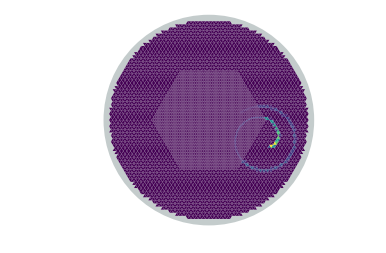

In [155]:
# create empty pad plane, then project simulated event onto pad plane

hits = np.zeros(10240)
for k, v in evtClean.items():
    hits[k] += v.max()
        
fig, sm = pad_plot(hits, scale='linear', cmap='viridis')

In [156]:
#Adding keys/values to dictionary event object for missing pads

for padAddress in range(0,10240):
    if (padAddress not in evtClean):
        evtClean[padAddress] = np.zeros(512)
        evtNoise[padAddress] = np.zeros(512)
        evtGaussianNoise[padAddress] = np.zeros(512)
    #else:
        #print("Pad " + str(padAddress) + " already in event")

In [157]:
print(len(evtClean))
print(len(evtNoise))
print(len(evtGaussianNoise))

10240
10240
10240


In [158]:
#renaming class
nm = NoiseMaker(config)

In [159]:
%%capture
# (evt, depress_baseline, gaussian_noise, clip)

evtNoise = nm.add_noise(evtNoise, True, True, True) #total noise

# different types of noise created seperately for analysis
evtNoiseNOCLIP = nm.add_noise(evtNoiseNOCLIP, True, True, False)
evtDepressNoise = nm.add_noise(evtDepressNoise, True, False, False)
evtGaussianNoise = nm.add_noise(evtGaussianNoise, False, True, False)
evtClipNoise = nm.add_noise(evtClipNoise, False, False, True)


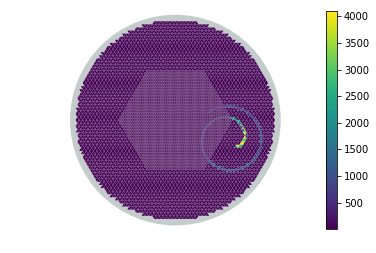

In [160]:
#project simulated noise onto pad plane

hits = np.zeros(10240)
for k, v in evtNoise.items():
    hits[k] += v.max()
        
fig, sm = pad_plot(hits, scale='linear', cmap='viridis')
plt.colorbar(sm)

#plt.savefig('/home/chen/pad_plot.pdf')


In [161]:
# converting simulated events to event objects

pyevtClean = sim.convert_event(evtClean)
pyevtNoise = sim.convert_event(evtNoise)

pyevtNoiseNOCLIP = sim.convert_event(evtNoiseNOCLIP)
pyevtDepressNoise = sim.convert_event(evtDepressNoise)
pyevtGaussianNoise = sim.convert_event(evtGaussianNoise)
pyevtClipNoise = sim.convert_event(evtClipNoise)



In [162]:
print(pyevtClean)
print(pyevtNoise)
print(pyevtDepressNoise)
print(pyevtGaussianNoise)
print(pyevtClipNoise)
# depress & clip are only based on tracks while others are generated through all 10240 electrode pads

Event 0, timestamp 0.
Contains 10240 traces.
Event 0, timestamp 0.
Contains 10240 traces.
Event 0, timestamp 0.
Contains 325 traces.
Event 0, timestamp 0.
Contains 10240 traces.
Event 0, timestamp 0.
Contains 325 traces.


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)
/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


Text(0,0.5,'y [mm]')

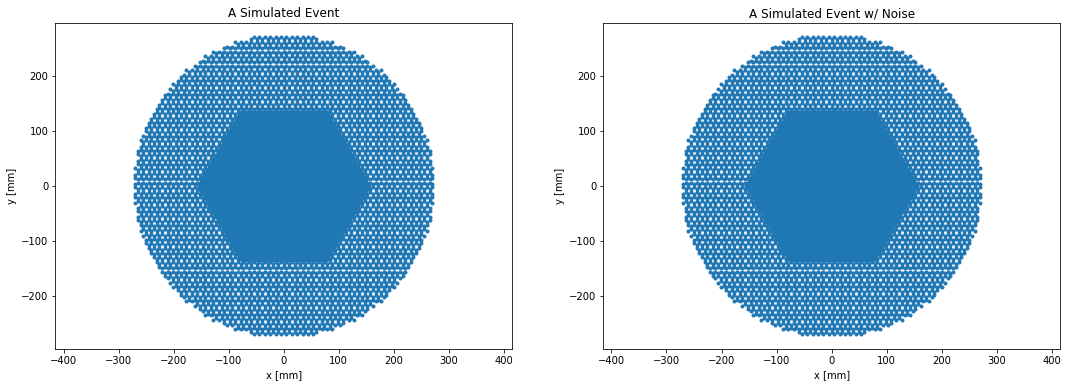

In [169]:
fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(18, 6))

new_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[0].plot(new_xyzs[:,0], new_xyzs[:,1], '.')
ax[0].axis('equal')
    
ax[0].set_title('A Simulated Event')
    
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')

####################################################################################################################
new_xyzs_Noise = pyevtNoise.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
ax[1].plot(new_xyzs_Noise[:,0], new_xyzs_Noise[:,1], '.')
ax[1].axis('equal')
    
ax[1].set_title('A Simulated Event w/ Noise')
    
ax[1].set_xlabel('x [mm]')
ax[1].set_ylabel('y [mm]')
